In [2]:
import os
from glob import glob

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import Model
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras import backend as K

%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
X_train = np.load("256_192_train.npy")

In [4]:
y_train = np.load("train_labels.npy")

In [5]:
X_val = np.load("256_192_val.npy")

In [6]:
y_val = np.load("val_labels.npy")

In [7]:
X_train.shape, X_val.shape

((8111, 192, 256, 3), (902, 192, 256, 3))

In [8]:
y_train.shape, y_val.shape

((8111,), (902,))

In [9]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

In [10]:
pre_trained_model = InceptionV3(input_shape=(192, 256, 3), include_top=False, weights="imagenet")

87910968/87910968 [==============================] - 2s 0us/step


In [11]:
for layer in pre_trained_model.layers:
    print(layer.name)
    if hasattr(layer, 'moving_mean') and hasattr(layer, 'moving_variance'):
        layer.trainable = True
        K.eval(K.update(layer.moving_mean, K.zeros_like(layer.moving_mean)))
        K.eval(K.update(layer.moving_variance, K.zeros_like(layer.moving_variance)))
    else:
        layer.trainable = False

print(len(pre_trained_model.layers))

input_1
conv2d
batch_normalization
activation
conv2d_1
batch_normalization_1
activation_1
conv2d_2
batch_normalization_2
activation_2
max_pooling2d
conv2d_3
batch_normalization_3
activation_3
conv2d_4
batch_normalization_4
activation_4
max_pooling2d_1
conv2d_8
batch_normalization_8
activation_8
conv2d_6
conv2d_9
batch_normalization_6
batch_normalization_9
activation_6
activation_9
average_pooling2d
conv2d_5
conv2d_7
conv2d_10
conv2d_11
batch_normalization_5
batch_normalization_7
batch_normalization_10
batch_normalization_11
activation_5
activation_7
activation_10
activation_11
mixed0
conv2d_15
batch_normalization_15
activation_15
conv2d_13
conv2d_16
batch_normalization_13
batch_normalization_16
activation_13
activation_16
average_pooling2d_1
conv2d_12
conv2d_14
conv2d_17
conv2d_18
batch_normalization_12
batch_normalization_14
batch_normalization_17
batch_normalization_18
activation_12
activation_14
activation_17
activation_18
mixed1
conv2d_22
batch_normalization_22
activation_22
conv2d

In [12]:
last_layer = pre_trained_model.get_layer('mixed10')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

last layer output shape: (None, 4, 6, 2048)


In [13]:
# Flatten the output layer to 1 dimension
x = layers.GlobalMaxPooling2D()(last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)
# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(7, activation='softmax')(x)

# Configure and compile the model

model = Model(pre_trained_model.input, x)
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

c:\Users\chara_eoccfea\anaconda3\envs\py310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 192, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 95, 127, 32)  864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 95, 127, 32)  96         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [15]:
train_datagen = ImageDataGenerator(rotation_range=60, width_shift_range=0.2, height_shift_range=0.2,
                                   shear_range=0.2, zoom_range=0.2, fill_mode='nearest')

train_datagen.fit(X_train)

val_datagen = ImageDataGenerator()
val_datagen.fit(X_val)

In [16]:
batch_size = 64
epochs = 3
history = model.fit_generator(train_datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = val_datagen.flow(X_val, y_val),
                              verbose = 1, steps_per_epoch=(X_train.shape[0] // batch_size), 
                              validation_steps=(X_val.shape[0] // batch_size))

C:\Users\chara_eoccfea\AppData\Local\Temp\ipykernel_13408\3971016608.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_datagen.flow(X_train,y_train, batch_size=batch_size),


Epoch 1/3
126/126 [==============================] - 71s 359ms/step - loss: 1.4328 - accuracy: 0.6103 - val_loss: 1.6884 - val_accuracy: 0.6830
Epoch 2/3
126/126 [==============================] - 41s 326ms/step - loss: 1.0675 - accuracy: 0.6684 - val_loss: 1.0256 - val_accuracy: 0.6830
Epoch 3/3
126/126 [==============================] - 43s 339ms/step - loss: 1.0318 - accuracy: 0.6738 - val_loss: 0.9778 - val_accuracy: 0.6719


In [17]:
for layer in pre_trained_model.layers[249:]:
    layer.trainable = True

In [18]:
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])

In [19]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, 
                                            min_lr=0.000001, cooldown=2)

In [20]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 192, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 95, 127, 32)  864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 95, 127, 32)  96         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [21]:
batch_size = 64
epochs = 35
history = model.fit_generator(train_datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = val_datagen.flow(X_val, y_val),
                              verbose = 1, steps_per_epoch=(X_train.shape[0] // batch_size),
                              validation_steps=(X_val.shape[0] // batch_size),
                              callbacks=[learning_rate_reduction])

C:\Users\chara_eoccfea\AppData\Local\Temp\ipykernel_13408\1245916579.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_datagen.flow(X_train,y_train, batch_size=batch_size),


Epoch 1/35
126/126 [==============================] - 48s 347ms/step - loss: 0.9210 - acc: 0.6880 - val_loss: 0.8878 - val_acc: 0.6786 - lr: 1.0000e-04
Epoch 2/35
126/126 [==============================] - 46s 361ms/step - loss: 0.7913 - acc: 0.7211 - val_loss: 0.7415 - val_acc: 0.7388 - lr: 1.0000e-04
Epoch 3/35
126/126 [==============================] - 48s 376ms/step - loss: 0.7239 - acc: 0.7431 - val_loss: 0.7535 - val_acc: 0.7076 - lr: 1.0000e-04
Epoch 4/35
126/126 [==============================] - 49s 388ms/step - loss: 0.6757 - acc: 0.7592 - val_loss: 0.5961 - val_acc: 0.7768 - lr: 1.0000e-04
Epoch 5/35
126/126 [==============================] - 52s 407ms/step - loss: 0.6335 - acc: 0.7732 - val_loss: 0.7601 - val_acc: 0.7522 - lr: 1.0000e-04
Epoch 6/35
126/126 [==============================] - 51s 401ms/step - loss: 0.6198 - acc: 0.7794 - val_loss: 0.7391 - val_acc: 0.7433 - lr: 1.0000e-04
Epoch 7/35
126/126 [==============================] - ETA: 0s - loss: 0.5751 - acc: 0.79

In [22]:
loss_val, acc_val = model.evaluate(X_val, y_val, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (acc_val, loss_val))

29/29 [==============================] - 2s 73ms/step - loss: 0.6225 - acc: 0.7805
Validation: accuracy = 0.780488  ;  loss_v = 0.622515


In [24]:
X_test = np.load("256_192_test.npy")

In [25]:
y_test = np.load("test_labels.npy")
y_test = to_categorical(y_test)

In [27]:
loss_test, acc_test = model.evaluate(X_test, y_test, verbose=1)
print("Test: accuracy = %f  ;  loss = %f" % (acc_test, loss_test))

32/32 [==============================] - 2s 68ms/step - loss: 0.6705 - acc: 0.7984
Test: accuracy = 0.798403  ;  loss = 0.670496


In [28]:
model.save("InceptionV3FT.h5")

Text(0.5, 1.0, 'Training and validation loss')

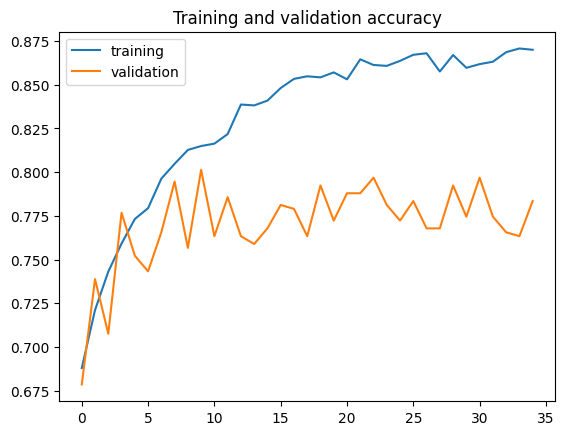

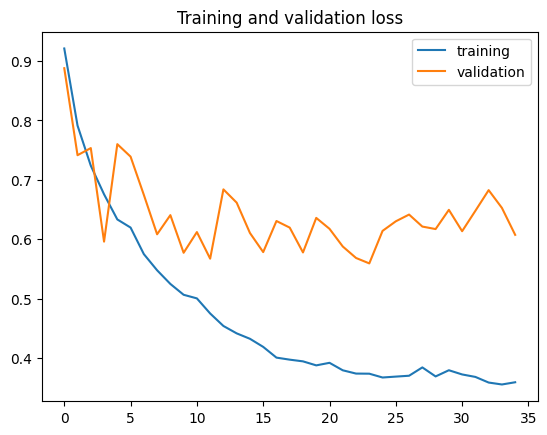

In [29]:
# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, label = "training")
plt.plot(epochs, val_acc, label = "validation")
plt.legend(loc="upper left")
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss, label = "training")
plt.plot(epochs, val_loss, label = "validation")
plt.legend(loc="upper right")
plt.title('Training and validation loss')